# Data visualization and budget set up

In [1]:
#pip install prophet

In [2]:
#pip install pathos

import packages

In [3]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

import matplotlib.pyplot as plt


In [4]:
pd.set_option('display.float_format', '{:.6f}'.format)


initial config file to config_dict

In [5]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/us/June 2024 Update/config ups us reg.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.08.2024


Query daily data

In [6]:
daily_df = GetBQData(training_query, _input, _output)
daily_df['day'] = daily_df.ds.dt.day
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year


/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


In [7]:
daily_df.ds.max()

Timestamp('2024-05-06 00:00:00')

In [9]:
pre_optimization_budget = daily_df[['year','X']].loc[(daily_df.month == 4) & 
                                                     (daily_df.year >= 2020) & (daily_df.day >= 25)].groupby(['year']).sum().mean()

In [10]:
pre_optimization_budget

X   148738.384179
dtype: float64

In [11]:
df = daily_df.copy()
df.market = region
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()


In [12]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]


In [13]:

df.loc[(df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31') & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)


,X,y,day,year
month,,,,
8,21325.390026,4353.000000,496,62651
9,21209.979991,2226.000000,465,60630
10,96834.210087,21358.000000,496,62651


In [14]:

df.loc[((df['ds'] >= '2019-03-01') & (df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)


,X,y,day,year
month,,,,
3,67101.870000,41748.000000,496,62589
4,72884.830000,37544.000000,465,60570
5,87523.080000,40007.000000,496,62589
6,119647.370000,42847.000000,465,60570
7,113451.400000,53325.000000,496,62589
8,128096.530000,59271.000000,496,62589


In [15]:
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
#df = df[df.ds < cutoff_month]
# remove inactive days
df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)
df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)

df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-12-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
       axis = 0, inplace = True)


In [16]:
df['year_month'] = df['ds'].dt.to_period('M')

BingAds_Generic = df.loc[((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].groupby(['year_month'])[['year_month','X','y']].sum(numeric_only=True).reset_index()


In [17]:
BingAds_Generic

,year_month,X,y
0,2017-08,1845.159992,621.000000
1,2017-09,29397.099931,296.000000
2,2017-10,79331.979401,771.000000
3,2017-11,63682.780014,431.000000
4,2017-12,68327.800074,599.000000
...,...,...,...
70,2024-01,1579.230000,205.000000
71,2024-02,1223.300000,179.000000
72,2024-03,777.230000,66.000000
73,2024-04,1717.750000,349.000000


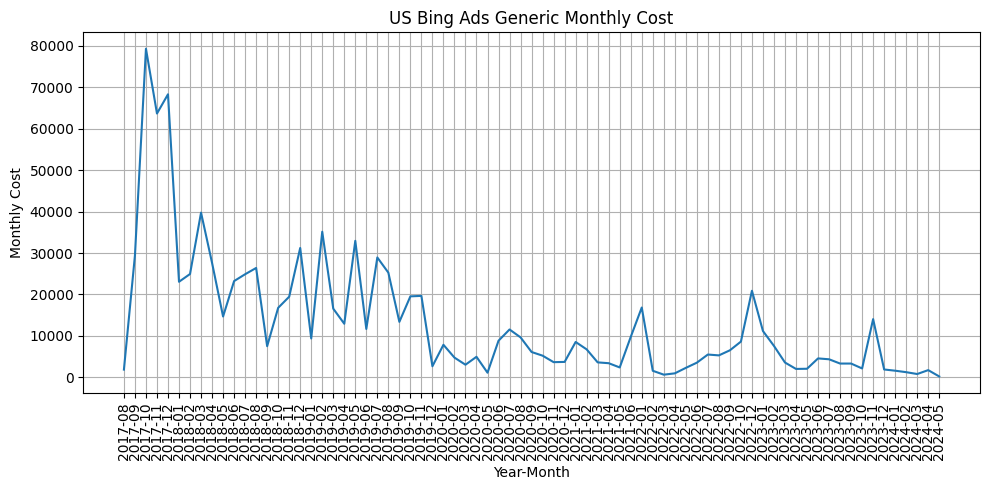

In [18]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(BingAds_Generic['year_month'].astype(str), BingAds_Generic['X'])  # Convert year_month to string for plotting
plt.title('US Bing Ads Generic Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

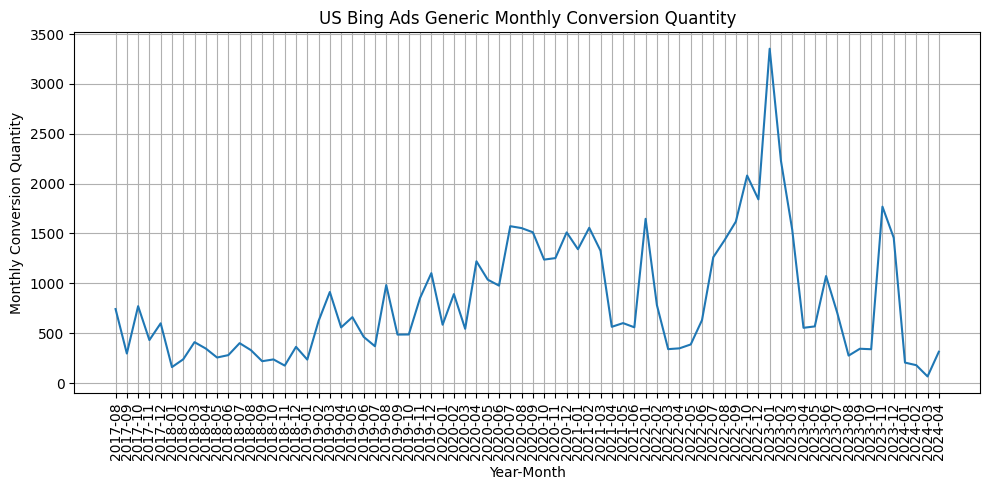

In [55]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(BingAds_Generic['year_month'].astype(str), BingAds_Generic['y'])  # Convert year_month to string for plotting
plt.title('US Bing Ads Generic Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()